In [2]:
# Import Dependencies
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine

In [3]:
# Create an engine for the hawaii.sqlite database
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [4]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [5]:
Base.classes.items()

[('measurements', sqlalchemy.ext.automap.measurements),
 ('stations', sqlalchemy.ext.automap.stations)]

In [6]:
# Save a reference to the stations table as `Station`
Station = Base.classes.stations

In [7]:
# Save a reference to the measurements table as `Measurement`
Measurement = Base.classes.measurements

In [8]:
# Create a database session object
from sqlalchemy.orm import Session
session = Session(engine)

In [9]:
# calculate the begin-date(using sqlalchemy) and end-date(using python object) to construct a 12 month time-window 
# in order to extract data for the past 12 months
from datetime import datetime
from datetime import timedelta
year = timedelta(days=365)

# get the latest date using the measurment table
end_date = session.query(Measurement.date,Measurement.prcp).order_by(Measurement.date.desc())[1][0]
# calulate the begin date
begin_date = end_date - year

In [10]:
from sqlalchemy import func
from sqlalchemy.sql import label
result_proxy = session.query(Measurement.date,label('prcp',func.avg(Measurement.prcp))).\
                filter(Measurement.date>=begin_date).\
                group_by(Measurement.date)

In [11]:
# instantitate an empty list called data to store the result proxy
data = []
for row in result_proxy:
    data.append({'date': row[0], 'prcp': row[1]})

In [12]:
# convert the result proxy to a pandas dataframe
import pandas as pd
df_prec = pd.DataFrame(data)
display(df_prec.head())
display(df_prec.shape)

,date,prcp
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000


(366, 2)

In [13]:
# set the index to date
df_prec = df_prec.set_index('date',drop=True)
display(df_prec.head())
display(df_prec.shape)

,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


(366, 1)

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
_ = df_prec.plot(figsize=(15,8))
_ = plt.xlabel('Date')
_ = plt.ylabel('Average Precipitation(Inches)')
_ = plt.title("Average Precipitation for the Period"+"\n"+"{} to {}".format(begin_date,end_date))
plt.show()

In [15]:
df_prec.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,366.0,0.170757,0.295683,0.0,0.008571,0.07,0.191667,2.38


In [16]:
# Design a query to calculate the total number of stations.
from sqlalchemy import distinct
number_of_stations = session.query(func.count(distinct(Measurement.station))).scalar()
print(f'The total number of stations : {number_of_stations}')

The total number of stations : 9


In [17]:
result_proxy = session.query(Measurement,Station,label('number_of_observations',func.count(Station.station))).\
                     join(Station).\
                     group_by(Station.station).\
                     order_by(func.count(Station.station).desc()).\
                     all()
data =[]      

for row in result_proxy:
    data.append({'station':row.stations.name,'number_of_observations':row.number_of_observations})

In [18]:
df = pd.DataFrame(data)
df= df[['station','number_of_observations']]
df.style.bar(subset=['number_of_observations'], align='mid', color=['#d65f5f'])

,station,number_of_observations
0,"WAIHEE 837.5, HI US",2772
1,"KANEOHE 838.1, HI US",2696
2,"WAIKIKI 717.2, HI US",2685
3,"WAIMANALO EXPERIMENTAL FARM, HI US",2572
4,"MANOA LYON ARBO 785.2, HI US",2484
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1937
6,"HONOLULU OBSERVATORY 702.2, HI US",1932
7,"PEARL CITY, HI US",683
8,"UPPER WAHIAWA 874.3, HI US",342


In [19]:
# Which station has the highest number of observations?
result_proxy = session.query(Measurement,Station,label('number_of_observations',func.count(Station.station))).\
                     join(Station).\
                     group_by(Station.station).\
                     order_by(func.count(Station.station).desc()).\
                     first()
    
most_active_station = result_proxy.stations.name
print(f'Station which has the highest number of observations : {most_active_station}')

Station which has the highest number of observations : WAIHEE 837.5, HI US


In [20]:
from sqlalchemy import func
from sqlalchemy.sql import label

result_proxy = session.query(Measurement,label('tobs',func.avg(Measurement.tobs))).\
                join(Station).\
                filter(Measurement.date>=begin_date).\
                filter(Station.name==most_active_station).\
                group_by(Measurement.date).all()

In [21]:
# instantitate an empty list called data to store the result proxy
data = []
for row in result_proxy:
    data.append({'date': row.measurements.date, 'tobs': row.measurements.tobs})

In [22]:
# convert the result proxy to a pandas dataframe
df_tobs = pd.DataFrame(data)
display(df_tobs.head())
display(df_tobs.info())

,date,tobs
0,2016-08-23,77
1,2016-08-24,77
2,2016-08-25,80
3,2016-08-26,80
4,2016-08-27,75


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 2 columns):
date    352 non-null datetime64[ns]
tobs    352 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.6 KB


None

In [23]:
# set the index to date
df_tobs.set_index('date',drop=True,inplace=True)

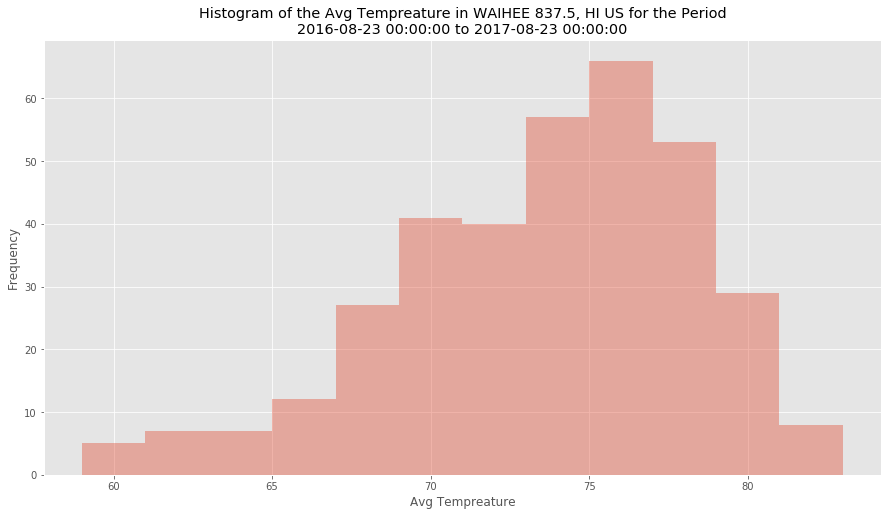

In [24]:
import seaborn as sns
plt.figure(figsize=(15,8))
_ = sns.distplot(df_tobs,bins=12,kde=False)
_ = plt.xlabel('Avg Tempreature')
_ = plt.ylabel('Frequency')
_ = plt.title("Histogram of the Avg Tempreature in {} for the Period".format(most_active_station)+"\n"+"{} to {}".format(begin_date,end_date))
plt.show();

In [25]:
from datetime import date
from sqlalchemy import and_

def calc_temps():
    '''the function will accept a start date and end date in the format %Y-%m-%d
    and return the minimum, average, and maximum temperatures for that range of dates and a plot to
    visualize the information'''
    
    date_entry = input('Enter the start date in YYYY-MM-DD format ')
    year, month, day = map(int, date_entry.split('-')) # map(function_to_apply, list_of_inputs)
    begin_date = date(year-1, month, day) # calculate the matching begin date from the previous year
    date_entry = input('Enter the end date in YYYY-MM-DD format ')
    year, month, day = map(int, date_entry.split('-'))
    end_date = date(year-1, month, day) # calculate the matching end date from the previous year
  
    result_proxy = session.query(Measurement.tobs).\
                    filter(and_(Measurement.date >=begin_date, Measurement.date <=end_date))

    data = []
    for result in result_proxy:
        data.append(result)

    df = pd.DataFrame(data)
    temp = dict({'min':df.min()[0],'max':df.max()[0],'mean':df.mean()[0]})
    avg = temp['mean']
    error = temp['max']-temp['min']
    
    plt.figure(figsize=(3,10))
    _ = plt.bar(left=1,height=avg, align='center', yerr = error)
    _ = plt.ylabel('Temp(F)')
    _ = plt.title('Trip Avg Temp')
    plt.axes().get_xaxis().set_visible(False)
    plt.show();

Enter the start date in YYYY-MM-DD format 2018-06-30
Enter the end date in YYYY-MM-DD format 2018-7-5


/Users/nicholashebert/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)
/Users/nicholashebert/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


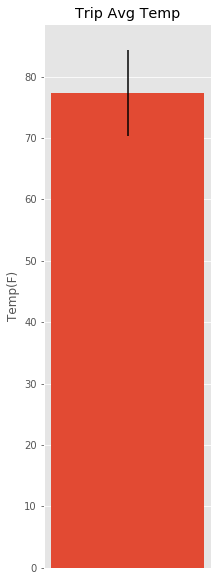

In [42]:
calc_temps()

In [43]:
# Calcualte the rainfall per weather station using the previous year's matching dates.
def dates_previous_year():
    
    '''the function will accept a start date and end date in the format %Y-%m-%d
    and returns the previous year's matching dates'''
        
    date_entry = input('Enter the start date in YYYY-MM-DD format ')
    year, month, day = map(int, date_entry.split('-')) # map(function_to_apply, list_of_inputs)
    begin_date = date(year-1, month, day) # calculate the matching begin date from the previous year
    date_entry = input('Enter the end date in YYYY-MM-DD format ')
    year, month, day = map(int, date_entry.split('-'))
    end_date = date(year-1, month, day) # calculate the matching end date from the previous year
  
    return dict({'start':begin_date,'end':end_date})

In [44]:
# get the previous year's matching dates
matching_dates = dates_previous_year()
start = matching_dates['start']
end = matching_dates['end']

Enter the start date in YYYY-MM-DD format 2017-06-30
Enter the end date in YYYY-MM-DD format 2017-07-05


In [45]:
# query the the rainfall per weather station using the previous year's matching dates.
result_proxy = session.query(Measurement,Station,Station.name,label('rainfall',func.avg(Measurement.prcp))).\
               join(Station).\
               filter(and_(Measurement.date >=start, Measurement.date <=end)).\
               group_by(Station.name).all()

In [46]:
# create an empty list to store the query results
data =[]      
for row in result_proxy:
    data.append({'station':row.stations.name,'RainFall':row.rainfall})

In [47]:
# covert the query results to a pandas dataframe
df = pd.DataFrame(data)
df= df[['station','RainFall']]
df.style.bar(subset=['RainFall'], align='mid', color=['#5fba7d'])

,station,RainFall
0,"KANEOHE 838.1, HI US",0.028
1,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0
2,"WAIHEE 837.5, HI US",0.062
3,"WAIKIKI 717.2, HI US",0.008
4,"WAIMANALO EXPERIMENTAL FARM, HI US",0.0666667


In [48]:
from datetime import date
startdate ='2017-01-15'
year,month,day = map(int,startdate.split('-'))
date(year,month,day)

datetime.date(2017, 1, 15)